# Uncertainty relation with qiskit: Excerpt from IBM class uncertainty module
### For class 2025 spring "Introduction to quantum information and quantum computing" Seoul National University, Department of Physics and Astronomy Instructor: Dohun Kim 

## Critical concepts:

- There are uncertainty relations between many sets of physical observables, including position & linear momentum, and components of spin. The last uncertainty relation is what we want to check in this qiskit example. 
- The Pauli matrices do not commute. This is a mathematical reflection of the fact that not all components of spin can be simultaneously known/determined.
- Quantum computing makes heavy use of the Pauli operators/matrices, so it is useful to know the uncertainty relation for Pauli operators, as well as the closely-related spin operators.
- A general formula for the uncertainty of two operators $A$ and $B$ is $$\Delta A \Delta B \geq \frac{1}{2}|\langle [A,B] \rangle|.$$
- An eigenstate $|a\rangle$ of some operator $A$ yields zero uncertainty in the physical observable associated with that operator. Even experimentally, $\langle a|A|a\rangle \approx 0.$
- An eigenstate $|a\rangle$ of some operator $A$ will yield a larger uncertainty for an operator $B$ that does not commute with $A$.
- Experimental results using a real quantum computer confirm the intuition we gain from matrix representations of physical operators.



## Qiskit Tip

You might recall that an eigenstate of one operator, Z, is not an eigenstate of another operator X. We will observe that now, experimentally by making measurements along the $x$ and $z$ axes. For the measurement along $z$, we simply use ```qc.measure()```, because IBM quantum computers are structured to measure along $z$. But to measure along $x$, we must rotate the system to effectively move the $x$ axis up to the orientation along which we measure. This is accomplished with a Hadamard gate. There is a similar step required for measurements along $y$. The necessary steps are collected here for convenience:

- To measure along $z$: ```qc.measure()```
- To measure along $x$: ```qc.h()``` then ```qc.measure()```
- To measure along $y$: ```qc.sdg()```, ```qc.h()```, ```qc.s```then ```qc.measure()```

If a student exhausts their available quantum computing time during the lesson, the lines below can be un-commented and used to set up a simulator that partly mimics the noise behavior of the quantum computer selected above.

We demonstrate the validity of the uncertainty relation for a single qubit by preparing the state somewhere on the Bloch sphere and measure uncertainties along various directions. Let's start by rotating our state vector away from the $z$ axis, using an ```RY``` gate to produce different initial states using a parameter $\theta$.

In [2]:
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import random

# Load the Qiskit Runtime service and backend
from qiskit_ibm_runtime import QiskitRuntimeService
token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127)
print(backend.name)

# Generate a local simulator that mimics the real quantum system
from qiskit_aer import AerSimulator
backend_sim = AerSimulator.from_backend(backend)

# Import primitives for local simulator
from qiskit.primitives import BackendSamplerV2, BackendEstimatorV2
sampler_sim = BackendSamplerV2(backend = backend_sim)
estimator_sim = BackendEstimatorV2(backend = backend_sim)

ibm_sherbrooke


### Step 1: Map the problem into a quantum circuit

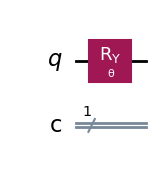

In [8]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister

# Specify observables
obs1 = SparsePauliOp("X")
obs2 = SparsePauliOp("Y")
obs3 = SparsePauliOp("Z")

# Define registers
qr = QuantumRegister(1, 'q')
cr = ClassicalRegister(1, 'c')
qc = QuantumCircuit(qr, cr)

# Rotate away from |0>
theta = Parameter("θ")
qc.ry(theta,0)

qc.draw("mpl")

### Step 2: Transpile the circuit

In [4]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
obs1_isa = obs1.apply_layout(layout=qc_isa.layout)
obs2_isa = obs2.apply_layout(layout=qc_isa.layout)
obs3_isa = obs3.apply_layout(layout=qc_isa.layout)

### Step 3: Run the circuit on a real quantum computer 

In [5]:
# Run the job on the Aer simulator with noise model from real backend - this part uses a local simulator
params = np.linspace(0, 2, num = 21)
job = estimator_sim.run([(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]], [params])], precision=0.01)
res = job.result()


If you want to get results from a real quantum computer, 

In [ ]:
# Load the Runtime primitive and session
from qiskit_ibm_runtime import Options, Session, Batch, SamplerV2 as Sampler, EstimatorV2 as Estimator

# with Batch(backend=backend) as batch:
#     estimator = Estimator(mode = batch)
#     pubs = [(qc_isa,[[obs1_isa],[obs2_isa],[obs3_isa]],[params])]
#     job = estimator.run(pubs, precision=0.01)
#     res = job.result()        
# batch.close()

### Step 4: Post-processing and classical analysis.



In [6]:
xs=res[0].data.evs[0]
ys=abs(res[0].data.evs[1])
zs=res[0].data.evs[2]

# Calculate uncertainties
import math
delx = []
delz = []
prodxz=[]
for i in range(len(xs)):
    delx.append(abs((1-xs[i]*xs[i]))**0.5)
    delz.append(abs((1-zs[i]*zs[i]))**0.5)
    prodxz.append(delx[i]*delz[i])

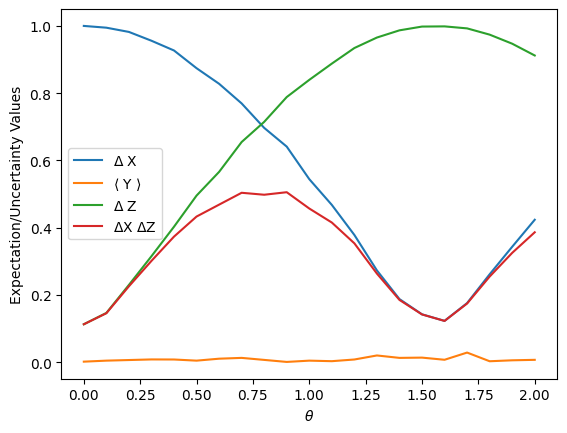

In [7]:
# Here we can plot the results from this simulation.
import matplotlib.pyplot as plt
plt.plot(params, delx, label=r'$\Delta$ X')
plt.plot(params, ys, label=r'$\langle$ Y $\rangle$')
plt.plot(params, delz, label=r'$\Delta$ Z')
plt.plot(params, prodxz, label=r'$\Delta$X $\Delta$Z')
plt.xlabel(r'$\theta$')
plt.ylabel('Expectation/Uncertainty Values')
plt.legend()
plt.show()

Note that the red curve $(\Delta X \Delta Z)$ is always greater than the orange curve $\langle Y \rangle.$ Sometimes the uncertainty product dips and is somewhat close to the limit, and other times it rises and is farther from the limit, but it always obeys the uncertainty relation.

Of course, this might not be the best test of the uncertainty relation, since our limit $\langle Y \rangle$ is always very close to zero. Let's use a quantum state that has a larger projection on eigenstates of $Y$. Specifically, we will still rotate rotate $|0\rangle$ down from the $z$ axis by varying angles, but now we will also rotate that resulting state around $z$ by some angle, perhaps $\pi/4$, and see what happens.

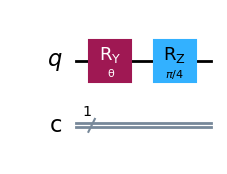

In [9]:
#Step 1: Map the problem to a quantum circuit
from qiskit.circuit import Parameter
import numpy as np

# Specify observables
obs1 = SparsePauliOp("X")
obs2 = SparsePauliOp("Y")
obs3 = SparsePauliOp("Z")

# Define registers
qr = QuantumRegister(1, 'q')
cr = ClassicalRegister(1, 'c')
qc = QuantumCircuit(qr, cr)

# Rotate away from |0> along one plane, and then along a transverse direction.
theta = Parameter("θ")
qc.ry(theta,0)
qc.rz(np.pi/4,0)

qc.draw("mpl")

In [10]:
# Step 2: Transpile the circuit
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)

obs1_isa = obs1.apply_layout(layout=qc_isa.layout)
obs2_isa = obs2.apply_layout(layout=qc_isa.layout)
obs3_isa = obs3.apply_layout(layout=qc_isa.layout)

In [11]:
# Step 3: Run the circuit on a real quantum computer

# Run the job on the Aer simulator with noise model from real backend
params = np.linspace(0, 2, num = 21)
job = estimator_sim.run([(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]], [params])], precision=0.01)
res = job.result()

# with Batch(backend=backend) as batch:
#     estimator = Estimator(mode = batch)
#     pubs = [(qc_isa,[[obs1_isa],[obs2_isa],[obs3_isa]],[params])]
#     job = estimator.run(pubs, precision=0.01)
#     res = job.result()
# batch.close()

In [12]:
# Step 4: Post-processing and classical analysis.
xs=res[0].data.evs[0]
ys=abs(res[0].data.evs[1])
zs=res[0].data.evs[2]

# Calculate uncertainties
import math
delx = []
delz = []
prodxz=[]
for i in range(len(xs)):
    delx.append(abs((1-xs[i]*xs[i]))**0.5)
    delz.append(abs((1-zs[i]*zs[i]))**0.5)
    prodxz.append(delx[i]*delz[i])

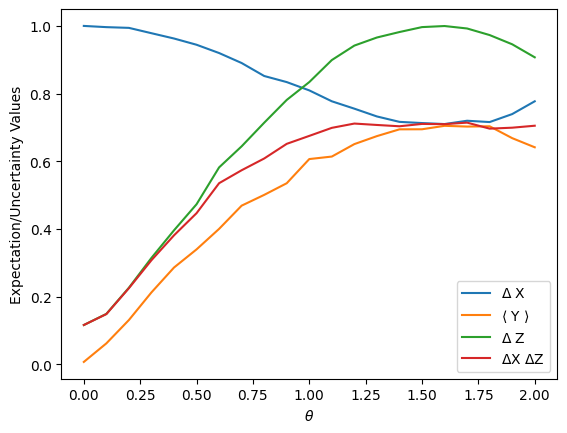

In [13]:
# Here we can plot the results from this simulation.
import matplotlib.pyplot as plt
plt.plot(params, delx, label=r'$\Delta$ X')
plt.plot(params, ys, label=r'$\langle$ Y $\rangle$')
plt.plot(params, delz, label=r'$\Delta$ Z')
plt.plot(params, prodxz, label=r'$\Delta$X $\Delta$Z')
plt.xlabel(r'$\theta$')
plt.ylabel('Expectation/Uncertainty Values')
plt.legend()
plt.show()